In [31]:
from thesispy.elastix_wrapper.wrapper import run
from thesispy.elastix_wrapper.parameters import Parameters, Collection
from pathlib import Path

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

2023-02-05 13:45:51,353 - Wrapper - INFO - Running elastix in: ../output/1675601151_learn_1_adaptivestochasticgradientdescent_352509
2023-02-05 13:46:05,160 - Validation - INFO - Calculating validation metrics for LEARN:
2023-02-05 13:46:05,161 - Validation - INFO - TRE: 2.1680078963580294
2023-02-05 13:46:05,161 - Validation - INFO - Bending Energy: 118.199
2023-02-05 13:46:05,278 - Validation - INFO - Jacobian min,max: 0.1464103643519962, 2.478554762749344
2023-02-05 13:46:05,330 - Validation - INFO - SDLogJ: 0.3461
2023-02-05 13:46:08,020 - Validation - INFO - Validation metrics calculated in 2.86s
2023-02-05 13:46:08,020 - Wrapper - INFO - Run ended. It took 16.6674 seconds


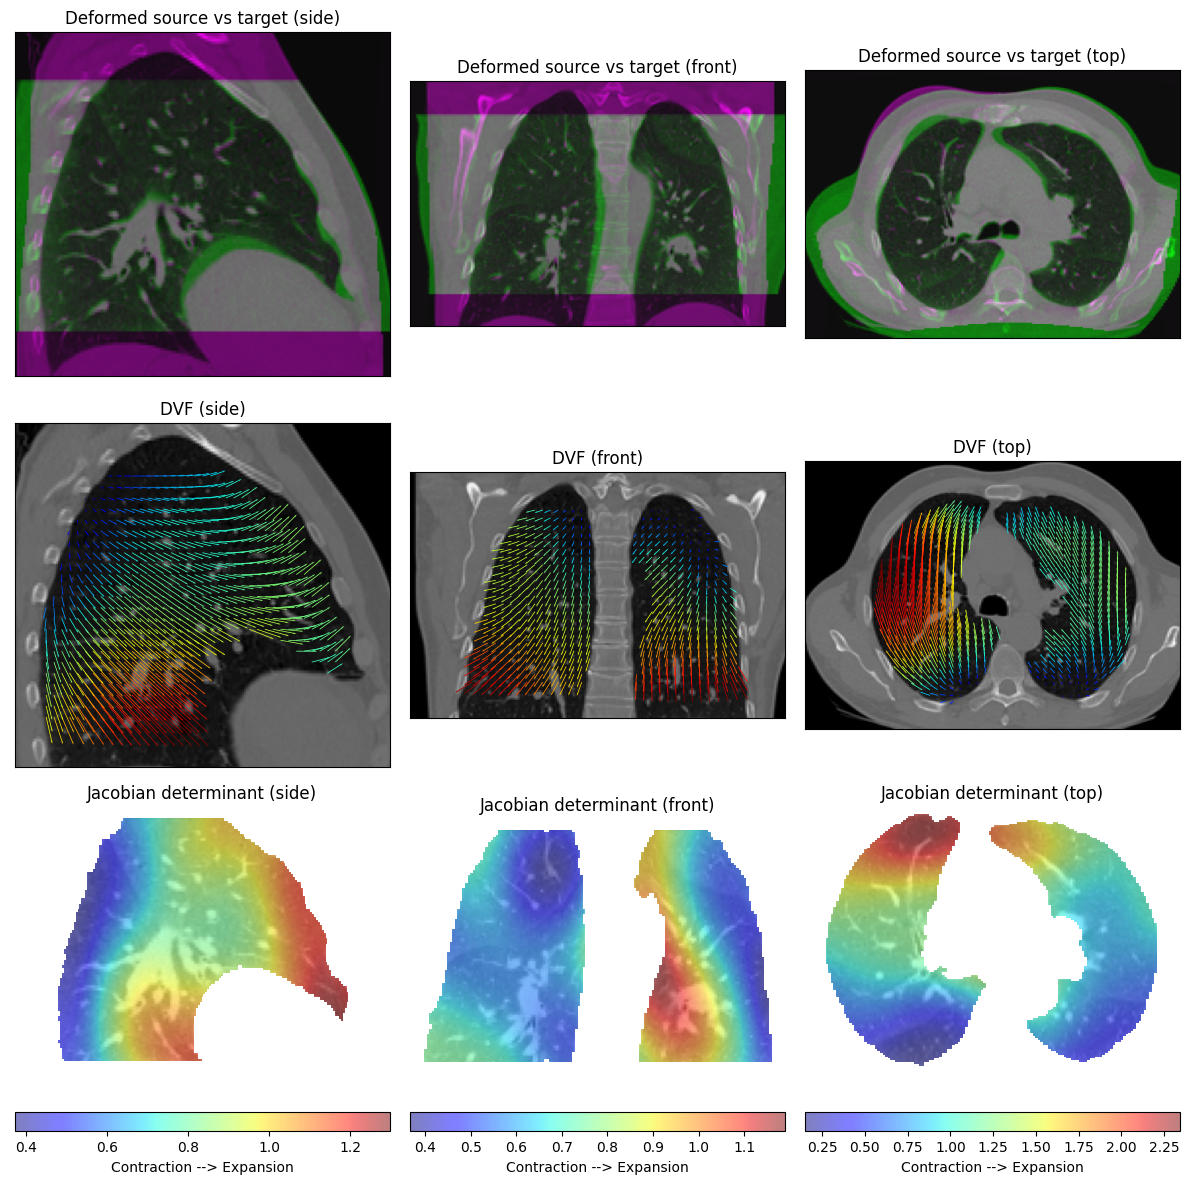

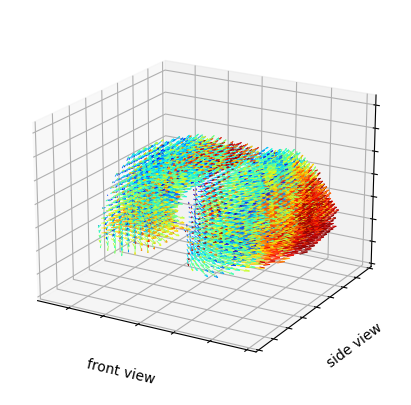

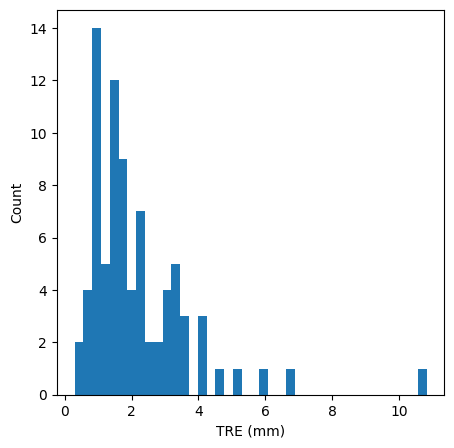

In [12]:
params = (
    Parameters.from_base(mesh_size=6, metric="AdvancedNormalizedCorrelation", seed=1, use_mask=True)
    .asgd()
    .regularize(0.01)
    .multi_resolution(3, p_sched=[6, 4, 2])
    .stopping_criteria(500)
    .instance(Collection.LEARN, 1)
)
run_result = run(params, Path("../output/" + str(params)), suppress_stdout=True, visualize=False, validate=True)

In [45]:
from thesispy.experiments.instance import read_controlpoints
import plotly.express as px
from pathlib import Path

cpoints = read_controlpoints(Path("controlpoints.R0.dat"))
cpoints = cpoints.reshape(-1, 3)
fig = px.scatter_3d(cpoints, x=0, y=1, z=2, opacity=0.6, width=500, height=500)
fig.show()

In [18]:
cpoints[0]

array([ 281.053,  200.929, -309.073])